In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time converters
from helpers import timestamp_to_unix_seconds as unix_seconds # Timestamps to Unix Seconds
from helpers import timestamp_to_unix_milliseconds as unix_milliseconds # Timestamps to Unix Milliseconds

In [52]:
EEG_FILEPATH = './samples/eeg_events/eeg.csv'
EVENTS_FILEPATH = './samples/eeg_events/events.csv'
OUTPUT_EVENTS_FILEPATH = './samples/eeg_events/eeg_events.csv'

In [53]:
# Read EEG
eeg_df = pd.read_csv(EEG_FILEPATH)

# Remove NA rows
eeg_df = eeg_df[~eeg_df['TimeStamp'].isna()] # Remove rows where timestamp is na
eeg_df = eeg_df[~eeg_df['Battery'].isna()]   # Remove battery rows - useless

# TimeStamp => Unix Milliseconds
eeg_df['unix_ms'] = eeg_df['TimeStamp'].apply(lambda x: int(unix_milliseconds(x)))

# Remove all TP channels, Accelerometer, Gyroscope, and raw data columns
eeg_df = eeg_df.loc[:,~eeg_df.columns.str.contains('TP', case=False)]
eeg_df = eeg_df.loc[:,~eeg_df.columns.str.contains('Accelerometer', case=False)]
eeg_df = eeg_df.loc[:,~eeg_df.columns.str.contains('Gyro', case=False)]
eeg_df = eeg_df.loc[:,~eeg_df.columns.str.contains('RAW', case=False)]
eeg_df = eeg_df.loc[:,~eeg_df.columns.str.contains('AUX', case=False)]

# Drop useless columns
eeg_df.drop(columns=['TimeStamp', 'Elements', 'Battery', 'HeadBandOn'], inplace=True)

eeg_df

,Delta_AF7,Delta_AF8,Theta_AF7,Theta_AF8,Alpha_AF7,Alpha_AF8,Beta_AF7,Beta_AF8,Gamma_AF7,Gamma_AF8,HSI_AF7,HSI_AF8,unix_ms
1,-0.358673,-0.174330,-0.177713,-0.124274,0.329615,0.154843,-0.270331,-0.174398,-0.289892,-0.625497,1.0,1.0,1741901455025
2,-0.321740,-0.155463,-0.216362,-0.152922,0.390894,0.184805,-0.193012,-0.140263,-0.325690,-0.680952,1.0,1.0,1741901455536
4,0.698471,0.672572,0.015400,0.093972,0.421022,0.346543,-0.172178,-0.124470,-0.348200,-0.649423,1.0,1.0,1741901456026
5,1.010309,0.964132,0.053169,0.125967,0.339316,0.308088,-0.146969,-0.148302,-0.344449,-0.598356,1.0,1.0,1741901456534
7,1.132271,0.990444,0.251953,0.120931,0.312366,0.305289,-0.105674,-0.140423,-0.226179,-0.265298,1.0,1.0,1741901457026
...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,-0.370996,0.020357,-0.468879,0.021219,0.056539,0.130198,-0.018083,0.124420,-0.221901,-0.191761,1.0,1.0,1741901700525
556,0.367116,0.089056,-0.340080,0.050220,-0.000708,0.133816,-0.010868,0.038866,-0.334726,-0.209524,1.0,1.0,1741901701025
557,0.740029,0.075553,-0.319281,-0.014113,-0.041824,0.149042,-0.008096,-0.074658,-0.392984,-0.250618,1.0,1.0,1741901701525
558,0.745816,0.036108,-0.233752,-0.237824,-0.086807,0.028618,-0.023392,-0.174309,-0.407578,-0.407075,1.0,1.0,1741901702025


In [54]:
events_df = pd.read_csv(EVENTS_FILEPATH)
events_df

,unix_ms,rel_timestamp,frame,event,side,screen_pos_x,screen_pos_y,screen_pos_z,target_name
0,1741901470139,0.0000,NaN,Activation,NaN,NaN,NaN,NaN,NaN
1,1741901470139,0.0000,279.0,NaN,Left,0.0000,0.0000,0.00000,NaN
2,1741901470139,0.0000,279.0,NaN,Right,0.0000,0.0000,0.00000,NaN
3,1741901470139,0.0000,279.0,NaN,Center,0.0000,0.0000,0.00000,NaN
4,1741901470457,0.0200,281.0,NaN,Left,710.0732,857.7388,49.76426,NaN
...,...,...,...,...,...,...,...,...,...
22369,1741901710608,240.1783,7969.0,Eye Hit,Left,790.2650,821.7684,49.68002,NorthSidewalk
22370,1741901710608,240.1783,7969.0,Eye Hit,Right,789.3773,821.7684,49.68002,NorthSidewalk
22371,1741901710608,240.1783,7969.0,Eye Hit,Center,789.8211,821.7684,49.68002,NorthSidewalk
22372,1741901710653,240.2231,7970.0,Eye Hit,Left,790.8470,824.5427,49.66745,NorthSidewalk


# Core Idea: Alignment

Need to align `unix_ms` in `events_df` with `unix_ms` from `eeg_df`. We know that `events_df` is likely to be captured at a higher sampling rate. Therefore, it is likely that multiple, consecutive rows in `events_df` will have the same EEG values. That's fine, but we need a system to be able to look at each `unix_ms` in `events_df`, check which `unix_ms` is the closest but smaller to that timestamp, and then join.

In [55]:
# Sort both dataframes by `unix_ms`
eeg_df = eeg_df.sort_values(by='unix_ms')
events_df = events_df.sort_values(by='unix_ms')

In [56]:
# Use numpy searchsorted to find the closest smaller `unix_ms` from eeg_df for each timestamp in events_df
indices = np.searchsorted(eeg_df['unix_ms'].values, events_df['unix_ms'].values, side='right') - 1
# Ensure indices are within bounds
indices = np.clip(indices, 0, len(eeg_df) - 1)

In [57]:
# Add the closest smaller `unix_ms`
events_df['closest_unix_ms'] = eeg_df['unix_ms'].iloc[indices].values

In [74]:
FBANDS = ['Theta', 'Alpha', 'Beta', 'Gamma']
ECHANNELS = ['AF7', 'AF8']

# Add the corresponding values from eeg_df into events_df
for band in FBANDS:
    for channel in ECHANNELS:
        colname = f"{band}_{channel}"
        events_df[colname] = 10 ** eeg_df[colname].iloc[indices].values
        
# Calculate the max possible value
maxs = []
for band in FBANDS:
    for channel in ECHANNELS:
        colname = f"{band}_{channel}"
        max_value = events_df[colname].max()
        maxs.append(max_value)
global_max = np.max(maxs)
print("Global Maximum:", global_max)

# Re-calcualte the relative values for each EEG column
for band in FBANDS:
    for channel in ECHANNELS:
        in_colname = f"{band}_{channel}"
        out_colname = f"Rel_{band}_{channel}"
        events_df[out_colname] = (events_df[in_colname] / global_max) * 100
        
# Cast relative values into ints
for band in FBANDS:
    for channel in ECHANNELS:
        colname = f"Rel_{band}_{channel}"
        events_df[colname] = events_df[colname].astype('int')

Global Maximum: 17.057133586606323


In [75]:
events_df

,unix_ms,rel_timestamp,frame,event,side,screen_pos_x,screen_pos_y,screen_pos_z,target_name,closest_unix_ms,...,Gamma_AF7,Gamma_AF8,Rel_Theta_AF7,Rel_Theta_AF8,Rel_Alpha_AF7,Rel_Alpha_AF8,Rel_Beta_AF7,Rel_Beta_AF8,Rel_Gamma_AF7,Rel_Gamma_AF8
0,1741901470139,0.0000,NaN,Activation,NaN,NaN,NaN,NaN,NaN,1741901470025,...,0.305832,0.622639,4,4,13,9,4,4,1,3
1,1741901470139,0.0000,279.0,NaN,Left,0.0000,0.0000,0.00000,NaN,1741901470025,...,0.305832,0.622639,4,4,13,9,4,4,1,3
2,1741901470139,0.0000,279.0,NaN,Right,0.0000,0.0000,0.00000,NaN,1741901470025,...,0.305832,0.622639,4,4,13,9,4,4,1,3
3,1741901470139,0.0000,279.0,NaN,Center,0.0000,0.0000,0.00000,NaN,1741901470025,...,0.305832,0.622639,4,4,13,9,4,4,1,3
4,1741901470457,0.0200,281.0,NaN,Left,710.0732,857.7388,49.76426,NaN,1741901470025,...,0.305832,0.622639,4,4,13,9,4,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22370,1741901710608,240.1783,7969.0,Eye Hit,Right,789.3773,821.7684,49.68002,NorthSidewalk,1741901702531,...,0.400773,0.262073,2,2,5,4,4,3,2,1
22369,1741901710608,240.1783,7969.0,Eye Hit,Left,790.2650,821.7684,49.68002,NorthSidewalk,1741901702531,...,0.400773,0.262073,2,2,5,4,4,3,2,1
22371,1741901710608,240.1783,7969.0,Eye Hit,Center,789.8211,821.7684,49.68002,NorthSidewalk,1741901702531,...,0.400773,0.262073,2,2,5,4,4,3,2,1
22372,1741901710653,240.2231,7970.0,Eye Hit,Left,790.8470,824.5427,49.66745,NorthSidewalk,1741901702531,...,0.400773,0.262073,2,2,5,4,4,3,2,1


In [76]:
events_df.to_csv(OUTPUT_EVENTS_FILEPATH, index=False)

# Extra Stats

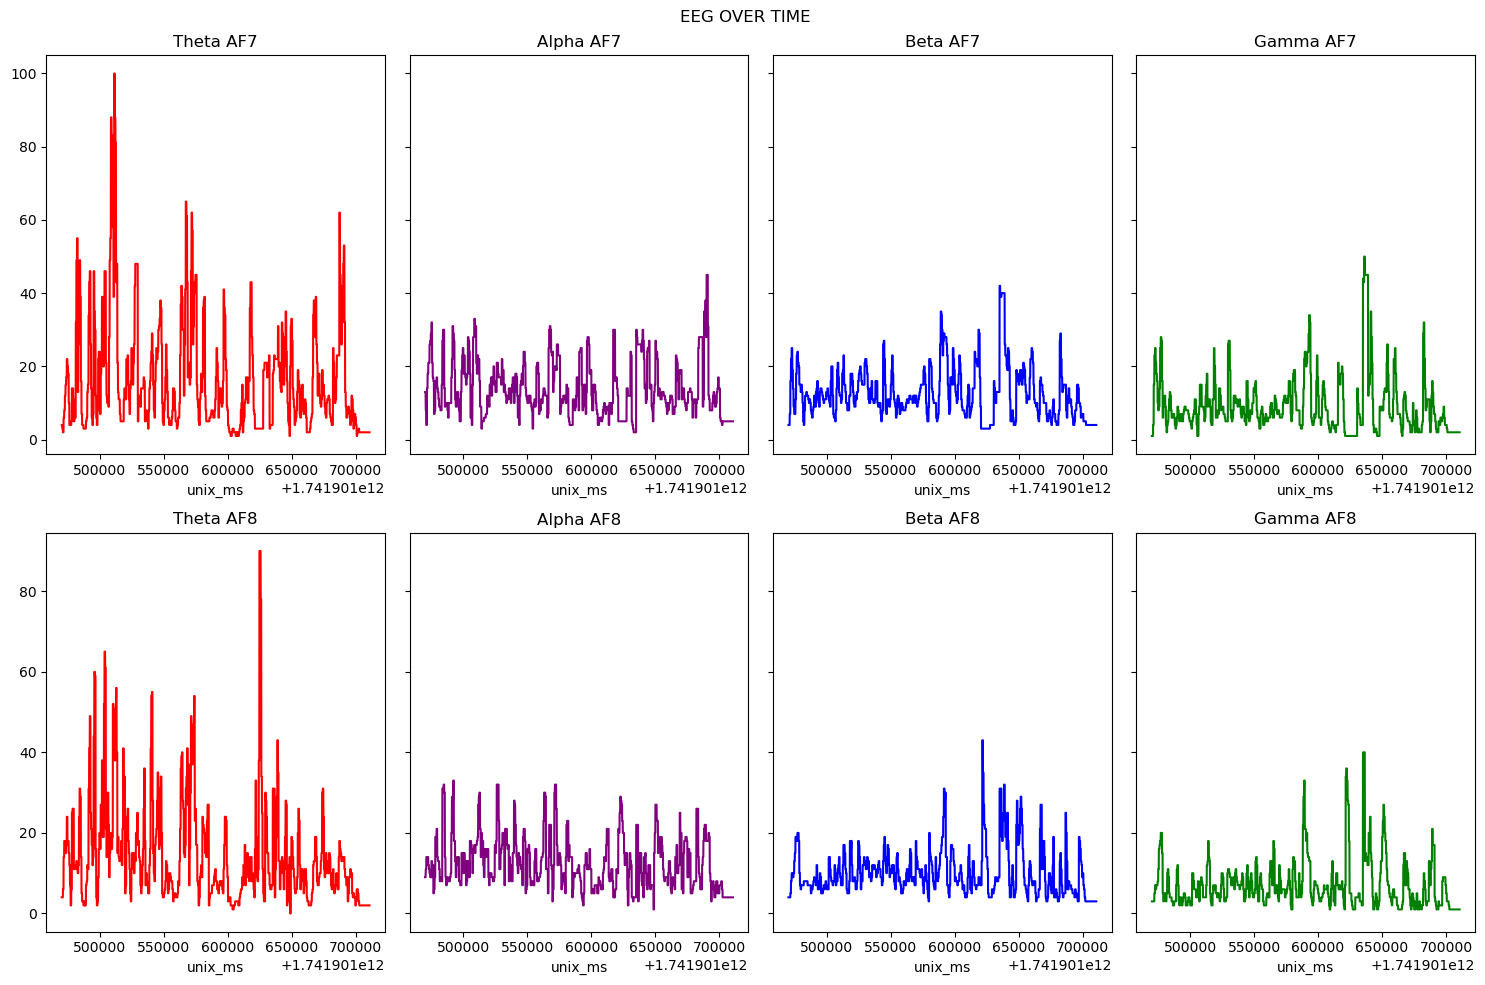

In [73]:
frequency_colors = ['red', 'purple', 'blue', 'green', 'orange']

fig, ax = plt.subplots(nrows=2, ncols=4, sharey='row')
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle("EEG OVER TIME")

for i in range(len(FBANDS)):
    color = frequency_colors[i]
    for j in range(len(ECHANNELS)):
        colname = f"Rel_{FBANDS[i]}_{ECHANNELS[j]}"
        title = f"{FBANDS[i]} {ECHANNELS[j]}"
        
        this_trial_ax = events_df.plot.line(x='unix_ms',y=colname, ax=ax[j,i], color=color, title=title)
        this_trial_ax.legend_ = None

plt.tight_layout()
plt.show()